In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# 'cs231n' folder containing the '.py', 'classifiers' and 'datasets'
# folders.
# e.g. 'cs231n/assignments/assignment1/cs231n/'
FOLDERNAME = 'cs231n/assignments/assignment1/cs231n/'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../
%cd ../../
%cd cs231n/datasets/
!bash get_datasets.sh
%cd ../../

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive
cp: cannot open 'cs231n/assignments/assignment1/cs231n/classifiers/linear_classifier.py.gdoc' for reading: Operation not supported
/content
/content/cs231n/datasets
--2020-05-26 01:13:11--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 

# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [0]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# # As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.424389
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$  

$L_i = -f_{y_i} + \log\sum_j e^{f_j}$

$f_{j}=0$

${L_i=0+log(10)=log(10)}$


In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.543819 analytic: -1.543819, relative error: 2.990441e-08
numerical: 0.921842 analytic: 0.921842, relative error: 4.929067e-08
numerical: -1.031575 analytic: -1.031575, relative error: 1.023140e-08
numerical: -2.853269 analytic: -2.853269, relative error: 1.650324e-08
numerical: 1.188247 analytic: 1.188247, relative error: 5.812791e-08
numerical: 1.608735 analytic: 1.608735, relative error: 3.324408e-08
numerical: -0.311642 analytic: -0.311642, relative error: 5.497366e-08
numerical: -1.934436 analytic: -1.934436, relative error: 3.793197e-08
numerical: 2.310092 analytic: 2.310092, relative error: 1.939125e-08
numerical: 0.620208 analytic: 0.620208, relative error: 1.369544e-07
numerical: -1.567725 analytic: -1.567726, relative error: 2.009890e-08
numerical: -1.784526 analytic: -1.784526, relative error: 1.744955e-08
numerical: -0.065525 analytic: -0.065525, relative error: 7.914474e-07
numerical: -2.164269 analytic: -2.164269, relative error: 1.155936e-08
numerical: 1.123

In [0]:
# def softmax_loss_vectorized(W, X, y, reg):
#     """
#     Softmax loss function, vectorized version.

#     Inputs and outputs are the same as softmax_loss_naive.
#     """
#     # Initialize the loss and gradient to zero.
#     loss = 0.0
#     dW = np.zeros_like(W)

#     #############################################################################
#     # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
#     # Store the loss in loss and the gradient in dW. If you are not careful     #
#     # here, it is easy to run into numeric instability. Don't forget the        #
#     # regularization!                                                           #
#     #############################################################################
#     # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#     num_train = X.shape[0]
#     num_classes = W.shape[1]

#     scores = X.dot(W)
#     shift_scores = scores - np.max(scores, axis=1).reshape(-1,1)

#     softmax_output = np.exp(shift_scores)/np.sum(np.exp(shift_scores),axis=1).reshape(-1,1)

#     loss = -np.log(softmax_output[range(num_train),y])
#     loss = np.mean(loss)
#     loss += reg*np.sum(W*W)

#     softmax_output_copy = softmax_output.copy()
#     # softmax_output is N,C. minus 1 in i,y[i]
#     adjust = np.zeros_like(softmax_output)
#     adjust[range(num_train),y] = -1
#     softmax_output_copy += adjust

#     # (D,N) * (N,C); 
#     dW = (X.T).dot(softmax_output_copy)
#     dW = dW/num_train
#     dW += 2*reg*W

#     # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#     return loss, dW


In [7]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.424389e+00 computed in 0.192424s
vectorized loss: 2.424389e+00 computed in 0.019653s
Loss difference: 0.000000
Gradient difference: 0.000000


In [22]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
# learning_rates = [1e-7, 5e-7]
learning_rates = np.linspace(6e-7,9e-7,4)
# regularization_strengths = [2.5e4, 5e4]
regulation_strengths = np.linspace(2e4, 3e4, 21)

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
  for reg in regulation_strengths:
    softmax = Softmax()
    tic = time.time()
    softmax.train(X_train, y_train, lr, reg, num_iters=100)
    y_val_pred = softmax.predict(X_val)
    y_train_pred = softmax.predict(X_train)
    train_accuracy = np.mean(y_train_pred == y_train)
    val_accuracy = np.mean(y_val_pred == y_val)

    results[(lr,reg)] = (train_accuracy, val_accuracy)
    if val_accuracy > best_val:
      best_val = val_accuracy
      best_softmax = softmax


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 6.000000e-07 reg 2.000000e+04 train accuracy: 0.303061 val accuracy: 0.309000
lr 6.000000e-07 reg 2.050000e+04 train accuracy: 0.318286 val accuracy: 0.328000
lr 6.000000e-07 reg 2.100000e+04 train accuracy: 0.323204 val accuracy: 0.326000
lr 6.000000e-07 reg 2.150000e+04 train accuracy: 0.315898 val accuracy: 0.315000
lr 6.000000e-07 reg 2.200000e+04 train accuracy: 0.313143 val accuracy: 0.334000
lr 6.000000e-07 reg 2.250000e+04 train accuracy: 0.317490 val accuracy: 0.338000
lr 6.000000e-07 reg 2.300000e+04 train accuracy: 0.312653 val accuracy: 0.342000
lr 6.000000e-07 reg 2.350000e+04 train accuracy: 0.311980 val accuracy: 0.321000
lr 6.000000e-07 reg 2.400000e+04 train accuracy: 0.315041 val accuracy: 0.314000
lr 6.000000e-07 reg 2.450000e+04 train accuracy: 0.320714 val accuracy: 0.330000
lr 6.000000e-07 reg 2.500000e+04 train accuracy: 0.310429 val accuracy: 0.316000
lr 6.000000e-07 reg 2.550000e+04 train accuracy: 0.321510 val accuracy: 0.334000
lr 6.000000e-07 reg 2.600000

In [23]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.365000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$



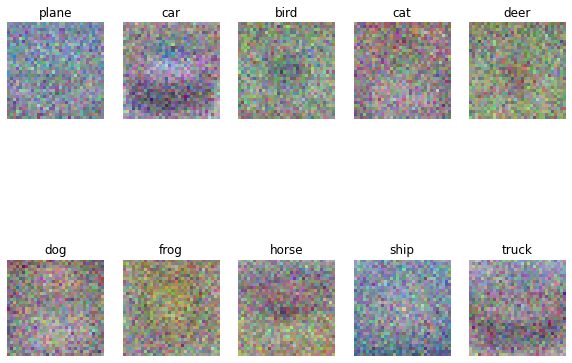

In [24]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

---
# IMPORTANT

This is the end of this question. Please do the following:

1. Click `File -> Save` to make sure the latest checkpoint of this notebook is saved to your Drive.
2. Execute the cell below to download the modified `.py` files back to your drive.

In [0]:
import os

FOLDER_TO_SAVE = os.path.join('drive/My Drive/', FOLDERNAME)
FILES_TO_SAVE = ['cs231n/classifiers/softmax.py']

for files in FILES_TO_SAVE:
  with open(os.path.join(FOLDER_TO_SAVE, '/'.join(files.split('/')[1:])), 'w') as f:
    f.write(''.join(open(files).readlines()))